# 1. Setup

## 1.1 Import Drivers

In [1]:
import logging
from logging import getLogger
import sys
import pynq
import time
from pynq import PL
import os, time

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

from pynq import Overlay
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.drivers.ifboard import IFBoard
from mkidgen3.drivers.ppssync import *
from mkidgen3.server.feedline_config import *
from mkidgen3.util import setup_logging
from mkidgen3.server.waveform import WaveformFactory

# 1.1.1 Set Board Timezone

In [2]:
os.environ['TZ'] = 'right/UTC'
time.tzset()

## 1.2 Setup Logging, Clocking, and Download Overlay

In [3]:
setup_logging('feedlinereadoutserver');
getLogger('pynq.interrupt').setLevel('DEBUG')
getLogger('pynq.uio').setLevel('DEBUG')

In [4]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/gen3_top_mts_22_30t_intcfix.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='external')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()
ol.rfdc.enable_mts()

03:58:51 mkidgen3.drivers.rfdcclock:DEBUG    (MainThread) setting lmk to use external 10 MHz reference


03:58:58 mkidgen3.drivers.rfdc:INFO     (MainThread) RFDCHierarchy does not support switching ADCs


## 1.2.1 Start PPS SYNC

In [5]:
await ol.pps_synchronization.pps_synchronizer_con_0.start_engine(PPSMode.FORCE_START, skew = 1000*1000*1000,
                                                                  clk_period_ns=1/256e-3)

# 2. Digital Demod Test

## 2.1 Play Waveform

In [6]:
tones = np.array([250.0e6 + 107e3, 2.00062500e+08])
amplitudes = np.full(tones.size, fill_value=0.8/tones.shape[0])

In [7]:
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes, maximize_dynamic_range=False))

In [8]:
if not hasattr(ol, 'dac_table'):
    def dac_config(*args, **kwargs):
        packed_data = np.zeros(2 ** 20, dtype=np.uint16)
        data=kwargs['waveform'].output_waveform
        iload = data.real.astype(np.int16)
        qload = data.imag.astype(np.int16)
        for i in range(8):
            packed_data[i:data.size * 2:16] = iload[i::8]
            packed_data[i + 8:data.size * 2:16] = qload[i::8]
        ol.dactable.axi_bram_ctrl_0.mmio.array[:]=np.frombuffer(packed_data, dtype=np.uint32)
        time.sleep(1)
else:
    def dac_config(*args, **kwargs):
        ol.dac_table.configure(**kwargs)

In [9]:
dac_config(**waveform.settings_dict())

03:59:06 mkidgen3.server.waveform:DEBUG    (MainThread) Computing net waveform with 2 tones. For 2048 tones this takes about 7 min.


## 2.2 ADC Capture

03:59:08 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
03:59:08 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc
03:59:08 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
03:59:08 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc


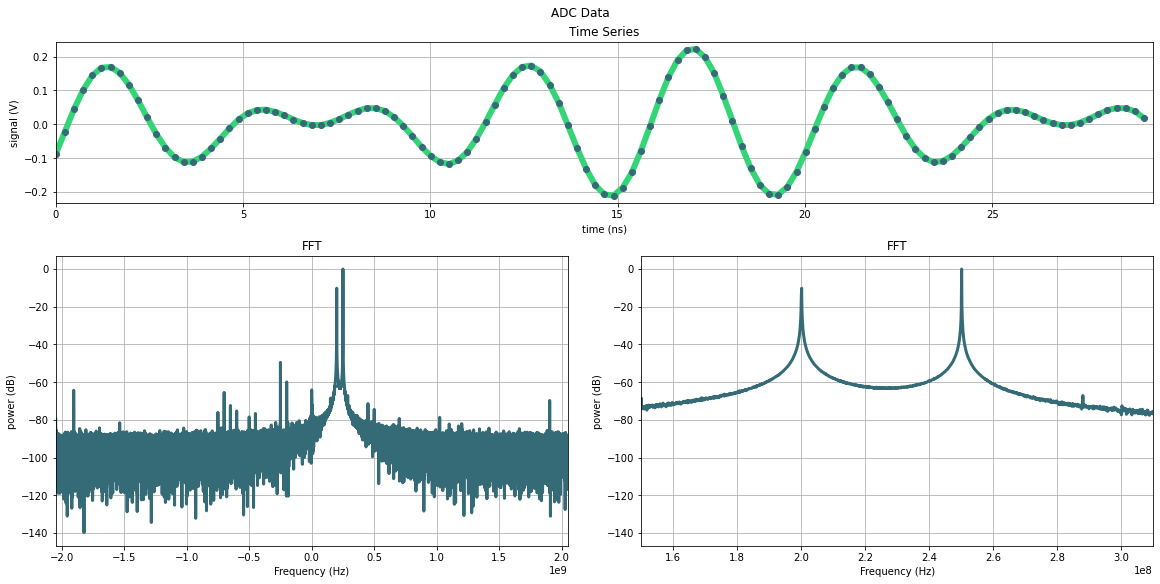

In [11]:
# Trigger Capture
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (1.5e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

## 2.3 DDC Test

### 2.3.1 Assign Resonator Channels

In [12]:
chan = waveform.default_channel_config
ol.photon_pipe.reschan.bin_to_res.configure(**chan.settings_dict())

### 2.3.2 Program DDC

In [13]:
ddc_tones = np.zeros(2048)
ddc_tones[:tones.size]=tones
ol.photon_pipe.reschan.ddccontrol_0.configure(tones=ddc_tones)

### 2.3.3 DDC Capture Compare

03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 8.0 MiB of data @ 16384.0 MiBps. ETA 0 ms
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 8388608 bytes (131072 beats) to address 0x500000000 from source rawiq
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 8.0 MiB of data @ 16384.0 MiBps. ETA 0 ms
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 8388608 bytes (131072 beats) to address 0x500000000 from source iq
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 8.0 MiB of data @ 16384.0 MiBps. ETA 0 ms
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 8388608 bytes (131072 beats) to address 0x500000000 from source iq
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing ~4.00 MB of data @ 4096.0 MBps. ETA 1 ms
03:59:12 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 4194304 bytes (65536 beats) to address 0x500000000 from sourc

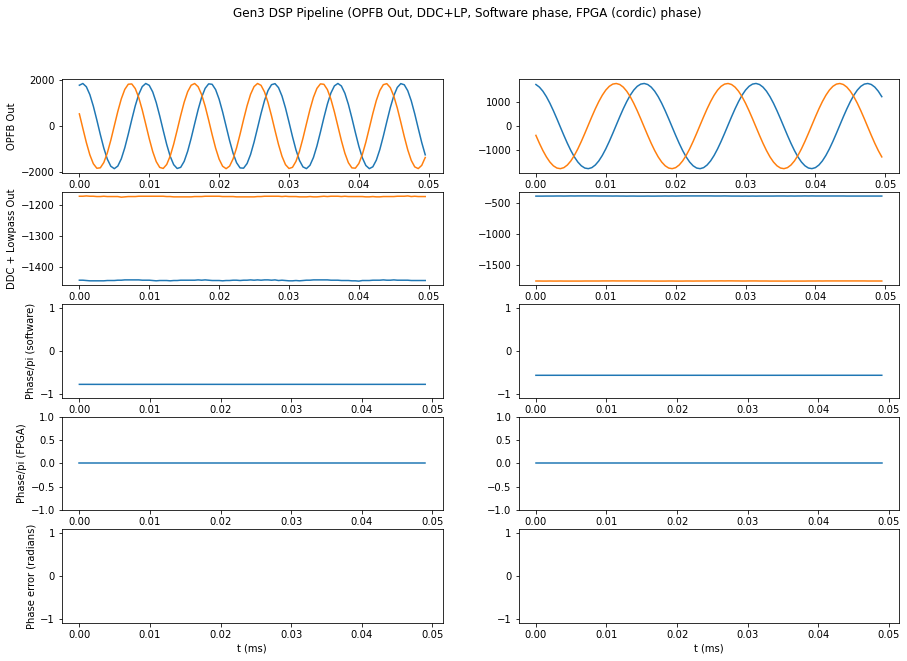

In [14]:
riq, iq = ol.capture.ddc_compare_cap()
iq, phase = ol.capture.cap_cordic_compare()
tonesplt = tones
chan_plt=[0,1]
bin_centers = g3.opfb_bin_center(g3.opfb_bin_number(tonesplt, ssr_raw_order=True), ssr_order=True)
fig, axes = plt.subplots(5,len(chan_plt), figsize=(15,10))
tones_khz=g3.drivers.ddc.tone_increments(tonesplt, quantize=True)*1e3
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plot_waveforms(riq[:100, i], 2e6, mode='iq', ax=ax[0], label='OPFB Out' if not j else '')
    plot_waveforms(iq[:100, i], 2e6, mode='iq', ax=ax[1], label='DDC + Lowpass Out' if not j else '')
    plot_waveforms(iq[:50, i], 1e6, mode='sw_phase', ax=ax[2], label='Phase/pi (software)' if not j else '')
    plot_waveforms(phase[:50, i]/2**15, 1e6, mode='phase', ax=ax[3], label='Phase/pi (FPGA)' if not j else '')
    plt.ylim([-1,1])
    err=np.angle(iq[:50, i])-np.pi*phase[:50, i]/2**15
    plot_waveforms(err, 1e6, mode='phase', ax=ax[4], label='Phase error (radians)' if not j else '')
    #plt.ylim([-1,1])
plt.suptitle('Gen3 DSP Pipeline (OPFB Out, DDC+LP, Software phase, FPGA (cordic) phase)');
del riq, iq, phase

### 2.3.4 Test Centering

In [15]:
# Load Zeros and Capture Uncentered Data
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)
x = ol.capture.capture_iq(1024, 'all', tap_location='ddciq')
iq_uncentered= np.array(x)
iq_uncentered = iq_uncentered[..., 0] + iq_uncentered[..., 1] * 1j
del x

03:59:17 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 8.0 MiB of data @ 16384.0 MiBps. ETA 0 ms
03:59:17 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 8388608 bytes (131072 beats) to address 0x500000000 from source iq


In [16]:
# Define Centers
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
centers[0:3] = [0+0.5*1j, 0-0.5*1j, 0.5+0*1j]

In [17]:
# Program Centers and Capture
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)
x = ol.capture.capture_iq(1024, 'all', tap_location='ddciq')
iq_centered= np.array(x)
iq_centered = iq_centered[..., 0] + iq_centered[..., 1] * 1j
del x

03:59:17 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 8.0 MiB of data @ 16384.0 MiBps. ETA 0 ms
03:59:17 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 8388608 bytes (131072 beats) to address 0x500000000 from source iq


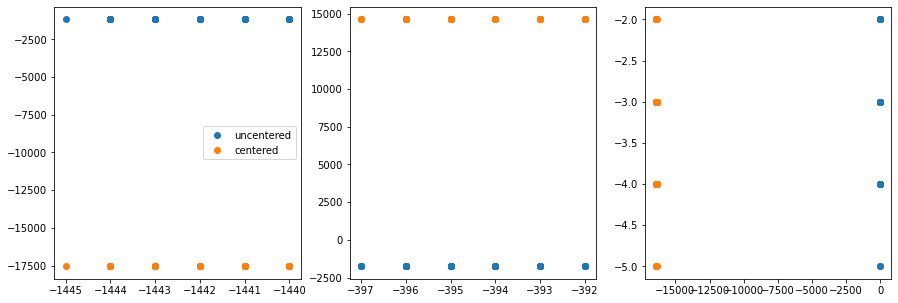

In [18]:
# Plot Results
chan_plt=[0,1,2]
fig, axes = plt.subplots(1,len(chan_plt), figsize=(15,5))
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    ax.plot(iq_uncentered[:,i].real, iq_uncentered[:,i].imag, "o", label="uncentered")
    ax.plot(iq_centered[:,i].real, iq_centered[:,i].imag, "o", label="centered")
    if j==0:
        ax.legend()
del iq_uncentered, iq_centered

In [19]:
centers = np.zeros(2048, dtype=np.complex64)
phase_offsets=np.zeros(2048)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, centers)

# 3 Test Photon Capture

## 3.1 Create Synthetic Photons

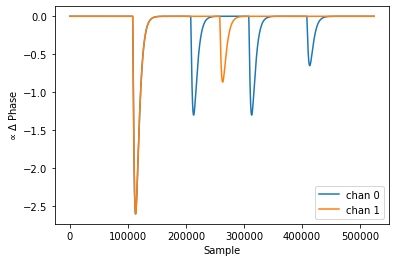

In [20]:
if not os.path.exists("pulse.npy"):
    # Generate a timestream proportional to the change in quasiparticle density
    quasiparticle_timestream = QuasiparticleTimeStream(fs = 4.096e9, ts = (2**19)/4.096e9)
    # Define a sudden change in quasiparticle density (caused by a photon)
    quasiparticle_timestream.gen_quasiparticle_pulse(tf=100) # 30 is realistic
    quasiparticle_timestream.data[quasiparticle_timestream.data.shape[0]//4:quasiparticle_timestream.data.shape[0]//4 + quasiparticle_timestream.photon_pulse.shape[0]] = quasiparticle_timestream.photon_pulse

    # Create resonator and compute S21
    resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1) #1e2
    rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0, cable_delay=50e-9)
    freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)

    plt.figure()
    quasiparticle_timestream.photon_pulse.shape
    plt.plot(quasiparticle_timestream.data)

    plt.figure()
    lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)
    theta1, d1 = lit_res_measurment.basic_coordinate_transformation()

    plt.plot(theta1)
    np.save("pulse.npy", theta1)

theta = np.load("pulse.npy")
theta[200_000:] += theta[:-200_000] / 2
theta[100_000:] += theta[:-100_000] / 2
theta2 = np.load("pulse.npy")
theta2[150_000:] += theta2[:-150_000] / 3
theta*=2*np.pi
theta2*=2*np.pi
plt.plot(theta, label='chan 0')
plt.plot(theta2, label='chan 1')
plt.xlabel('Sample')
plt.ylabel(r"$\propto \Delta$ Phase")
plt.legend(loc='lower right')

Inject `theta` modulation into the first tone and `theta2` into the second tone

In [21]:
phases = [-theta, -theta2]
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes, 
                                                   phases=phases, maximize_dynamic_range=False))

## 3.2 Start DAC Playing Synthetic Photons

In [22]:
dac_config(**waveform.settings_dict())

03:59:23 mkidgen3.server.waveform:DEBUG    (MainThread) Computing net waveform with 2 tones. For 2048 tones this takes about 7 min.


## 3.3 Program Matched Filter with unity coefficients

In [25]:
getLogger('mkidgen3.drivers.phasematch').setLevel('INFO')
# ol.photon_pipe.phasematch.N_TEMPLATE_TAPS=50

In [26]:
filtercfg=FilterConfig(coefficients=f'unity{tones.size}')
ol.photon_pipe.phasematch.configure(**filtercfg.settings_dict())

03:59:26 mkidgen3.drivers.phasematch:INFO     (MainThread) Configuring phasematch with unity2


## 3.4 Look at Photons with Phase Capture

In [23]:
x = ol.capture.capture_phase(2**8, 'all', tap_location='matchphase')
phase = np.array(x)
del x

03:59:24 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing ~1.00 MB of data @ 4096.0 MBps. ETA 0 ms
03:59:24 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 1048576 bytes (16384 beats) to address 0x500000000 from source rawphase


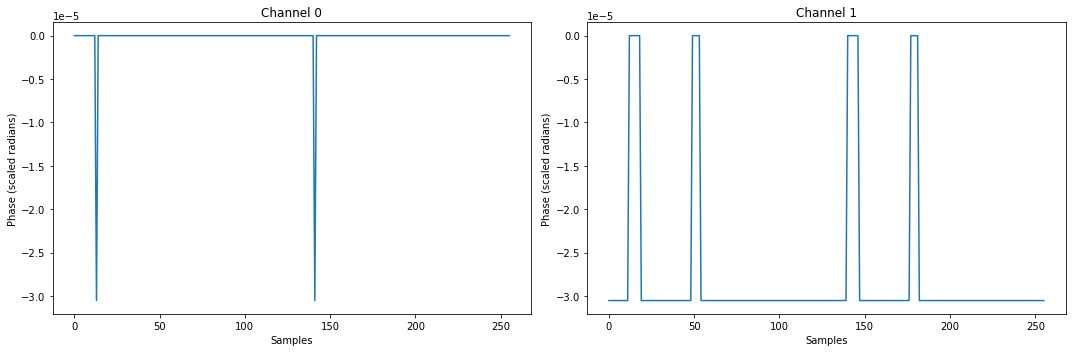

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(phase[:, 0]/2**15)
ax1.set_xlabel("Samples")
ax1.set_ylabel('Phase (scaled radians)')
ax1.set_title('Channel 0')
ax2.plot(phase[:, 1]/2**15)
ax2.set_xlabel("Samples")
ax2.set_ylabel('Phase (scaled radians)')
ax2.set_title('Channel 1')
plt.tight_layout()

## 3.5 Bias Phase

In [29]:
# Make Sure DDC Has No Offset
phase_offsets = np.zeros(2048)
ddc_centers = np.zeros(2048, dtype=np.complex64)
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [30]:
# Capture Raw Phase with No Offsetx = ol.capture.capture_phase(2**19, [0,1], tap_location='rawphase')
x = ol.capture.capture_phase(2**19, [0,1], tap_location='matchphase')
phase = np.array(x)
x.freebuffer()

03:59:55 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing ~32.00 MB of data @ 64.0 MBps. ETA 500 ms
03:59:55 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 33554432 bytes (524288 beats) to address 0x500000000 from source rawphase


In [31]:
# Compute Phase Needed to Move Averge to Zero
raw_phase = phase/(2**15-1)
phase_offsets = np.zeros(2048)
phase_offsets[:tones.size] = -np.pi*raw_phase[:, :tones.size].mean(axis=0)

In [32]:
# Program DDC With New Offsets
ol.photon_pipe.reschan.ddccontrol_0.configure(ddc_tones, phase_offsets, ddc_centers, center_relative=False, quantize=True)

In [33]:
# Capture Data
x = ol.capture.capture_phase(2**10, [0,1], tap_location='matchphase')
phase = np.array(x)
x.freebuffer()
moved_phase = phase/(2**15-1)

03:59:57 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing ~0.06 MB of data @ 64.0 MBps. ETA 1 ms
03:59:57 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 65536 bytes (1024 beats) to address 0x500000000 from source rawphase


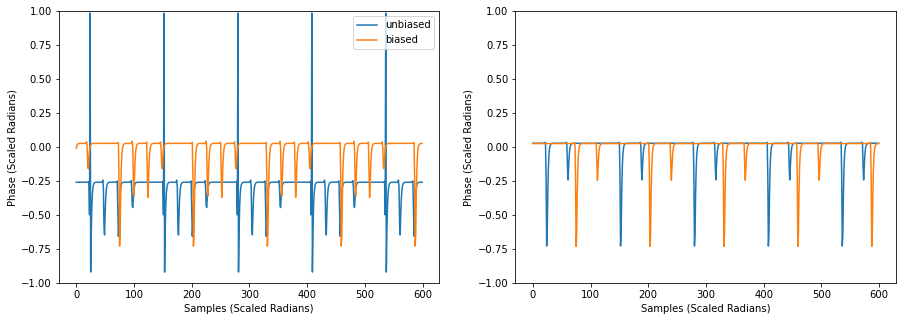

In [34]:
# Plot
chan_plt=[0,1]
fig, axes = plt.subplots(1, len(chan_plt), figsize=(15,5))
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    plt.sca(ax)
    plt.plot(raw_phase[:600,i], label='unbiased')
    plt.plot(moved_phase[:600,i], label='biased')
    plt.ylim(-1, 1)
    plt.ylabel('Phase (Scaled Radians)')
    plt.xlabel('Samples (Scaled Radians)')
    if j==0:
        ax.legend()
del raw_phase, moved_phase

##  3.7 Set Trigger Thresholds and Holdoffs

In [35]:
thresholds = -0.5*np.ones(2048)
thresholds[2:] = -0.99
holdoffs = np.full(2048, fill_value=20, dtype=np.uint16)

In [36]:
x = ol.capture.capture_phase(2**10, [0,1], tap_location='matchphase')
phase = np.array(x)/(2**15-1)
x.freebuffer()

04:00:10 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing ~0.06 MB of data @ 64.0 MBps. ETA 1 ms
04:00:10 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 65536 bytes (1024 beats) to address 0x500000000 from source rawphase


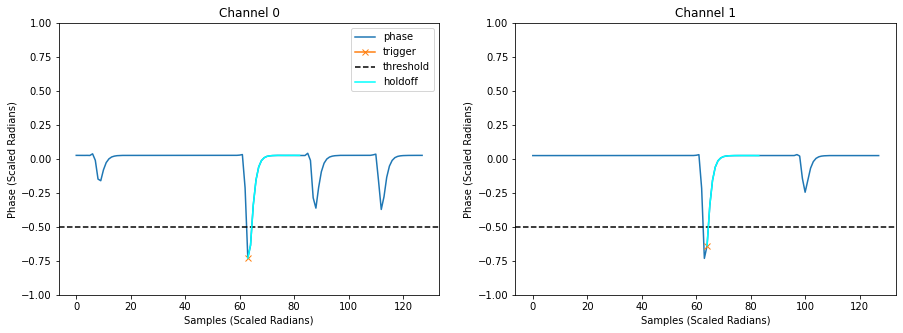

In [37]:
# Visualize Thresholds and Holdoffs
chan_plt=[0,1]
fig, axes = plt.subplots(1, len(chan_plt), figsize=(15,5))
samples = np.arange(128)
for j,(i, ax) in enumerate(zip(chan_plt,axes.T)):
    trig = phase[:128,i]<thresholds[i]
    holdoff = slice(samples[trig][i], samples[trig][i]+holdoffs[i])
    plt.sca(ax)
    plt.plot(samples, phase[:128,i], label='phase')
    plt.plot(samples[trig][i], phase[:128,i][trig][i], marker='x', label='trigger')
    plt.axhline(thresholds[i], linestyle='--', color='black', label='threshold')
    plt.plot(samples[holdoff], phase[:128,i][holdoff], color='cyan', label='holdoff')
    plt.title(f'Channel {i}')

    plt.ylim(-1, 1)
    plt.ylabel('Phase (Scaled Radians)')
    plt.xlabel('Samples (Scaled Radians)')
    if j==0:
        ax.legend()

In [38]:
ol.trigger_system.trigger_1.configure(thresholds, holdoffs)

In [39]:
n_photons = 2 # number of photons trigger across channels each dac replay cycle
expected_rate = 4.096e9/2**19 *n_photons  # per pulse below threshold

## Postage Stamp

In [40]:
def process_postage(buffer, floating=True, omit_first=True):
    """
    convert postage stamp capture data into rids and associated complex values, 
    by default omit the first, garbage stamp
    """
    if isinstance(buffer, pynq.buffer.PynqBuffer):
        buffer = np.array(buffer)
    # first photon is generally garbage
    start=int(omit_first)
    d=buffer[start:,1:,0]+buffer[start:,1:,1]*1j
    if floating:
        d/=(2**15-1)
    rid = buffer[start:,0,0]
    return rid, d

In [41]:
ol.trigger_system.postage_filter_0.configure(monitor_channels=[0,1,2,3,4,5,6,7])

In [42]:
d=ol.trigger_system.postage_maxi_0.capture() # caputres 8000 events
# time.sleep(8000/expected_rate*1.01*2)
ol.trigger_system.postage_maxi_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=1, RESERVED_3=0),
  GIER = Register(Enable=1, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=1, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=1, CHAN1_INT_ST=0, RESERVED_0=0),
  iq_1 = Register(iq=write-only),
  iq_2 = Register(iq=write-only),
  event_count = Register(event_count=8000, RESERVED=0),
  event_count_ctrl = Register(event_count_ap_vld=1, RESERVED=0),
  max_events = Register(max_events=write-only, RESERVED=write-only)
}

In [43]:
monitor_channels = ol.trigger_system.postage_filter_0.monitor_channels
rid, stamp = process_postage(d, floating=False)
[(rid==i).sum() for i in monitor_channels], monitor_channels

([4000, 3998, 0, 1, 0, 0, 0, 0], (0, 1, 2, 3, 4, 5, 6, 7))

/tmp/ipykernel_1314/2193987361.py:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(np.abs(stamp[rid==chan][:200]), origin='lower')


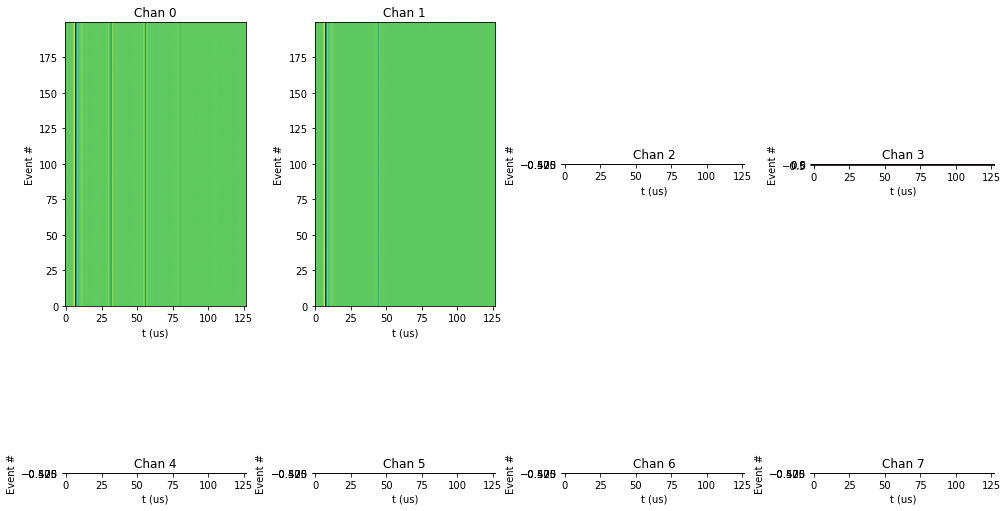

In [44]:
fig, ax = plt.subplots(2,4 , figsize=(14,10))
for i, (chan, ax) in enumerate(zip(monitor_channels, ax.ravel())):
    plt.sca(ax)
    plt.title(f'Chan {chan}')
    plt.imshow(np.abs(stamp[rid==chan][:200]), origin='lower')
    plt.ylabel('Event #')
    plt.xlabel('t (us)')
plt.tight_layout()

## Photon Capture

In [48]:
tsub=ol.trigger_system
self=ol.trigger_system.photon_maxi_0

In [49]:
MAX_PERMISSIBLE_PER_BUFFER = 2 ** 16 - 1  #photons, that is
MAX_PERMISSIBLE_PER_BUFFER/expected_rate, expected_rate

(4.19424, 15625.0)

In [50]:
tsub.photon_maxi_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  photons_out_1 = Register(photons_out=write-only),
  photons_out_2 = Register(photons_out=write-only),
  Memory_n_photons = Register(value=0),
  active_buffer = Register(active_buffer=0, RESERVED=0),
  active_buffer_ctrl = Register(active_buffer_ap_vld=0, RESERVED=0),
  photons_per_buf = Register(photons_per_buf=write-only, RESERVED=write-only),
  time_shift = Register(time_shift=write-only, RESERVED=write-only)
}

In [51]:
from mkidgen3.drivers.trigger import PhotonMAXI
class PixelMap:
    
    """ The attribute map_bins is a tuple of the pixel bin edges i.e. for histograms"""
    def __init__(self, map, nx, ny=0):
        """ 
        A Pixel to channel mapping
        
        nx: the number of x pixels
        ny: the number of y pixels, 0 if 1d
        map: is a 1 or 2d array channel id to pixel coordinate. 1d is for linear arrays or 
        single feedlines. Will be coerced to integer.
    
        """
        self.map = map.astype(int)
        self.nx=max(nx,1)
        self.ny=max(ny,0)
        assert (ny>0) == (map.ndim==2)
        maxn=self.map.max(axis=-1)
        ok =  maxn[0]<self.nx and maxn[1]<self.ny if ny else maxn<self.nx
        assert ok, "Mapped pixels out of bounds"

        if not ny:
            self.map_bins=(np.arange(self.nx+1,dtype=int), )
        else:
            self.map_bins=np.arange(self.nx+1,dtype=int), np.arange(self.ny+1, dtype=int)
                
class PhotonAccumulator:
    def __init__(self, max_ram=100, pixelmap:PixelMap=None, n_channels=None):
        """
        A tool to gather photons together without running out of ram and ease access 
        to timeseries, images, and other helpful metrics.
        
        max_ram: how much space to allow for photon storage
        pixelmap: and optional channel id to x or xy map, should be a nChan x 1 or 2 array positions 
        n_channels: optional shortcut if pixelmap not specified
        """
        assert bool(n_channels) ^ bool(pixelmap), 'Must specify n_channels xor pixelmap'
        self.ram_limit = max_ram  # MiB
        self.map = pixelmap if pixelmap else PixelMap(np.arange(n_channels, dtype=int), n_channels)
        self._data=np.zeros(self.ram_limit*1024**2//PhotonMAXI.PHOTON_DTYPE.itemsize, dtype=PhotonMAXI.PHOTON_DTYPE)
        self.n=0

    def __getitem__(self, n):
        """Get photons for channel n"""
        return self.data[self.data['id']==n]
        
    def accumulate(self, buffer, n):
        """Add some packed photons to the pot"""
        d=np.array(buffer[:n])
        drop=max(n-(self._data.size-self.n), 0)
        if drop:
            getLogger(__name__).debug(f'Memory used up, dropping {drop} old photons.')
            self._data[:self._data.size-drop]=self._data[drop:]
        PhotonMAXI.unpack_photons(buffer[:n], out=self._data, n=self.n)
        self.n+=n-drop
        
    @property
    def data(self):
        return self._data[:self.n]
    
    def image(self, timestep_us=None, rate=False):
        """ Build an image out of the current photon data, specify a timestep (in us) to make a timecube"""
        
        first, last = self.data['time'][[0,-1]]
        duration_s = (last-first)/1e6
        if first>=last:
            raise ValueError('Last photon time is not after the first!')
            
        if timestep_us:
            timebins = (np.arange(first, last+timestep_us, timestep_us, dtype=type(timestep_us)),)
        else:
            timebins = tuple()
        imbins = self.map.map_bins
    
        val = self.map.map[self.data['id']]
        val = (val,) if self.map.map.ndim==1 else (val[0], val[1])
        coord = val + (self.data['time'],) if timestep_us else val
        
        hist, _ = np.histogramdd(coord, bins=imbins+timebins, density=rate)
        if rate:
            hist*=self.n
            hist/=duration_s if timestep is None else 1e6

        return hist

In [52]:
from mkidgen3.drivers.trigger import WaitMode
accum = PhotonAccumulator(max_ram=250, n_channels=2048)

capture_dur_s = 10

tsub.photon_maxi_0.stop_capture()
time.sleep(2)
buf = tsub.photon_maxi_0.capture(buffer_time_ms=1000)
interval = tsub.photon_maxi_0.buffer_interval/1000. #to seconds
i=0

while capture_dur_s>0:
        slept=time.perf_counter()
        
        tsub.photon_maxi_0.wait(method=WaitMode.POLL)

        slept=time.perf_counter()-slept
        
        print(f'Waited {slept*1e3:.1f} ms for interrupt, reading occupancy & active buffer')
        
        cnta, cntb, ab_i = tsub.photon_maxi_0.mmio.array[8:11]  # about 66% faster that a pair of reads, about 64-140 us
        ab_i &= 0xff
        count = cnta if ab_i else cntb
        count &= 0x1ffff

        if i>=2: # first three aren't great
            slept=time.perf_counter()
            accum.accumulate(buf[0 if ab_i else 1], count)
            slept=time.perf_counter()-slept
            capture_dur_s-=interval
            print(f' Accumulated in {slept*1e3:.1f} ms')
            
        i+=1

tsub.photon_maxi_0.stop_capture()

04:00:58 mkidgen3.drivers.trigger:INFO     (MainThread) Requested rotation interval 1000.00 ms rounded to 1048.58 ms
Waited 852.1 ms for interrupt, reading occupancy & active buffer
Waited 1048.2 ms for interrupt, reading occupancy & active buffer
Waited 1048.3 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.1 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.2 ms for interrupt, reading occupancy & active buffer
 Accumulated in 2.0 ms
Waited 1046.1 ms for interrupt, reading 

In [53]:
phots=accum[1]
phots.size*12/1024**2 #MiB in channel 1

0.9375

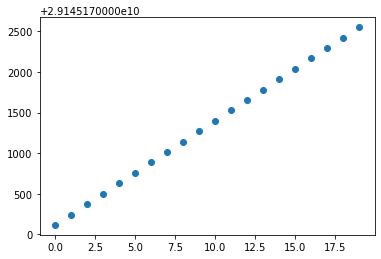

In [54]:
plt.plot(phots['time'][:20],"o")

In [55]:
slept=time.perf_counter()
x=accum.image(timestep_us=1000)
slept=time.perf_counter()-slept
print(f'Imaged in {slept*1e3:.1f} ms')

Imaged in 211.4 ms


In [56]:
x.shape,set(accum[1]['phase']/(2**15-1)), set(np.diff(accum[0]['time']))

((2048, 10486),
 {-0.7322305978576006,
  -0.7320169682912686,
  -0.7319864497817926,
  -0.7317728202154606,
  -0.7317423017059846,
  -0.7315591906491287},
 {128})

In [57]:
#No droped photons, but depends on what the threshold was set to!
set(np.diff(accum[0]['time']))=={128} # 1 photon on  chan 0

True

## Interrupt Spot Check

In [45]:
from pynq.interrupt import _InterruptController

In [46]:
_InterruptController._uio_devices[121].__dict__['uio'].__dict__

{'name': '/dev/uio4'}

In [47]:
import os
os.getpid()

1314

# Interrupts

In [58]:
from pynq.interrupt import Interrupt
import pynq.uio as puio
import pynq.interrupt as pi
import asyncio
from threading import Thread
import time
bob=[]
john={}

getLogger('pynq.interrupt').setLevel('DEBUG')
getLogger('pynq.uio').setLevel('DEBUG')

async def monitor_interrupt(what):
    print(f"Waiting on {what} at {time.strftime('%X')}")
    i=Interrupt(what)
    global john
    john[what]=i
    cnt=0
    while cnt<4:
        await i.wait()
        bob.append(f"Interrupt {what} @ {time.time()}")
        getLogger('pynq.interrupt').info(f"Interrupt {what} @ {time.time()}")
        cnt+=1
    
    
def clear_int(core):
    given_int = isinstance(core, pynq.Interrupt)
    interrupt = core if given_int else core.interrupt

    int_number = interrupt.number
    
    if not given_int and core.register_map.IP_ISR.CHAN0_INT_ST:
        print('core interrupt cleared')
        
    val = 1<<int_number
    parent_mmio = interrupt.parent().mmio
    if not (parent_mmio.read(0x8) & val):
        print('interrupt is not enabled at controler')
    if parent_mmio.read(0x4) & val:
        parent_mmio.write(0x0C, val)
        print('core interrupt controler state cleared')
        
        
def start_background_loop(loop: asyncio.AbstractEventLoop) -> None:
    asyncio.set_event_loop(loop)
    loop.run_forever()
        

# ol.axi_intc_0.register_map
interrput_names = [k for k,_ in PL.interrupt_pins.items() if not 'xlc' in k]
x=[(k, v['index']) for k,v in PL.interrupt_pins.items() if not 'xlc' in k]
pic =  ol.trigger_system.postage_maxi_0.interrupt.parent()
uio = pic.parent
aic = ol.axi_intc_0
ol_interrupts = {n: pynq.Interrupt(n) for n,_ in x}
x

[('rfdc/usp_rf_data_converter_0/irq', 0),
 ('pps_synchronization/pps_synch_0/running', 1),
 ('trigger_system/photon_maxi_0/interrupt', 2),
 ('trigger_system/postage_maxi_0/interrupt', 3),
 ('capture/axis2mm/o_int', 4),
 ('Clocktree/RF_CLKGEN/interrupt', 5),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_data_tlast_missing', 6),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_data_tlast_unexpected',
  7),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_data_chanid_incorrect',
  8),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_config_tlast_missing',
  9),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_config_tlast_unexpected',
  10),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_reload_tlast_missing',
  11),
 ('photon_pipe/phasematch/matched_filter_512x0/event_s_reload_tlast_unexpected',
  12),
 ('photon_pipe/phasematch/reload/axi_fifo_mm_s_0/interrupt', 13)]

Start an asyncio thread that just waits on ALL the interrupts in the design

In [59]:
loop = asyncio.new_event_loop()
thread = Thread(target=start_background_loop, args=(loop,), daemon=True)
thread.start()

In [60]:
tasks = [asyncio.run_coroutine_threadsafe(monitor_interrupt(i), loop) for i in interrput_names]

Waiting on rfdc/usp_rf_data_converter_0/irq at 04:02:10
04:02:10 pynq.uio:DEBUG    (Thread-20 (start_background_loop)) UIO Adding Event: <pynq.interrupt._InterruptController object at 0xffff68271d50>, [], 0
04:02:10 pynq.uio:DEBUG    (Thread-20 (start_background_loop)) Enabling UIO Interrupts
Waiting on pps_synchronization/pps_synch_0/running at 04:02:10
Waiting on trigger_system/photon_maxi_0/interrupt at 04:02:10
Waiting on trigger_system/postage_maxi_0/interrupt at 04:02:10
Waiting on capture/axis2mm/o_int at 04:02:10
Waiting on Clocktree/RF_CLKGEN/interrupt at 04:02:10
Waiting on photon_pipe/phasematch/matched_filter_512x0/event_s_data_tlast_missing at 04:02:10
Waiting on photon_pipe/phasematch/matched_filter_512x0/event_s_data_tlast_unexpected at 04:02:10
Waiting on photon_pipe/phasematch/matched_filter_512x0/event_s_data_chanid_incorrect at 04:02:10
Waiting on photon_pipe/phasematch/matched_filter_512x0/event_s_config_tlast_missing at 04:02:10
Waiting on photon_pipe/phasematch/ma

Poke at some of the various states to see

In [ ]:
foo=[[x for x in y] for y in ol.trigger_system.postage_maxi_0.interrupt.parent().wait_handles]

In [ ]:
(uio.fired, 
 ol_interrupts['trigger_system/postage_maxi_0/interrupt'].event, 
 john['trigger_system/postage_maxi_0/interrupt'].event,
 ol.trigger_system.postage_maxi_0.interrupt.event, foo, bob)

In [61]:
puio.get_uio_index('fabric'), pi.get_uio_irq(121)

(4, '/dev/uio4')

Look at what may be relevant GIC registers, the base address may be wrong

In [62]:
GICD_BASE = 0xF901_0000
GICD_SIZE = 0x1000

GICD_ISENABLE = 0x100

gicd = pynq.MMIO(GICD_BASE, GICD_SIZE)

for i in range(4):
    print('{:032b}'.format((gicd.read(GICD_ISENABLE + i * 4))))

FABRIC_ISR = 121
print(gicd.read(GICD_ISENABLE + 4*(FABRIC_ISR // 32)) >> (FABRIC_ISR % 32))

01000000000000000000000011111111
00001110010111110000010000000000
00001001000000010000000000001000
00000010000111111110100001000010
1


In [66]:
!cat /proc/interrupts

           CPU0       CPU1       CPU2       CPU3       
 11:      43908      40822     143739      41179     GICv2  30 Level     arch_timer
 14:          0          0          0          0     GICv2  67 Level     zynqmp_ipi
 15:          0          0          0          0     GICv2 175 Level     arm-pmu
 16:          0          0          0          0     GICv2 176 Level     arm-pmu
 17:          0          0          0          0     GICv2 177 Level     arm-pmu
 18:          0          0          0          0     GICv2 178 Level     arm-pmu
 19:          0          0          0          0     GICv2 155 Level     axi-pmon, axi-pmon
 20:          0          0          0          0     GICv2 156 Level     zynqmp-dma
 21:          0          0          0          0     GICv2 157 Level     zynqmp-dma
 22:          0          0          0          0     GICv2 158 Level     zynqmp-dma
 23:          0          0          0          0     GICv2 159 Level     zynqmp-dma
 24:          0         

In [ ]:
bin(aic.register_map.ISR), bin(aic.register_map.IER)

See if we ever logged a uio callback event

In [70]:
uio.fired

['UIO firing event for <pynq.interrupt._InterruptController object at 0xffff68271d50> at 1704340957.800057']

## Do the UIO callback's job for it! 

In [ ]:
current_events = uio.wait_events
uio.wait_events = []
for e in current_events:
    e.set()

In [71]:
clear_int(ol_interrupts['capture/axis2mm/o_int'])
clear_int(ol.trigger_system.postage_maxi_0)

interrupt is not enabled at controler
core interrupt cleared
interrupt is not enabled at controler


In [72]:
buf=ol.trigger_system.postage_maxi_0.capture()
await ol.trigger_system.postage_maxi_0.interrupt.wait()

04:04:27 mkidgen3.drivers.trigger:DEBUG    (MainThread) Zeroing and reusing existing buffer
04:04:27 pynq.uio:DEBUG    (MainThread) Callback started waiting
04:04:27 pynq.uio:DEBUG    (MainThread) Callback recieved interrupt 33554432
04:04:27 pynq.uio:DEBUG    (MainThread) UIO firing event for <pynq.interrupt._InterruptController object at 0xffff68271d50>
IRQ 3: firing <asyncio.locks.Event object at 0xffff5df19c30 [unset, waiters:1]>
04:04:27 pynq.interrupt:DEBUG    (MainThread) IRQ 3: firing <asyncio.locks.Event object at 0xffff5df19c30 [unset, waiters:1]>
04:04:27 pynq.uio:DEBUG    (MainThread) UIO Adding Event: <pynq.interrupt._InterruptController object at 0xffff68271d50>, [], 0
04:04:27 pynq.uio:DEBUG    (MainThread) Enabling UIO Interrupts


In [69]:
buf=ol.trigger_system.postage_maxi_0.capture()
buf2=ol.capture.capture_adc(100, sleep=False, complex=False, use_interrupt=False)

04:03:42 mkidgen3.drivers.trigger:DEBUG    (MainThread) Zeroing and reusing existing buffer
04:03:42 mkidgen3.drivers.capture:DEBUG    (MainThread) Capturing 0.0003662109375 MB of data @ 16384 MB/s. ETA 0 ms
04:03:42 mkidgen3.drivers.capture:DEBUG    (MainThread) Starting capture of 384 bytes (6 beats) to address 0x500001000 from source adc


## Other code

In [ ]:
buf = ol.trigger_system.photon_maxi_0.capture(buffer_time_ms=1000)

In [ ]:
async def wait_for_photons():
    print(f"started wait @ {time.strftime('%X')}")
    ol.trigger_system.photon_maxi_0.capture(buffer_time_ms=1000)
    time.sleep(.3)
    ol.trigger_system.photon_maxi_0.register_map.IP_ISR
    time.sleep(.05)
    ol.axi_intc_0.register_map.IAR = (1<<2)
    while True:
        print(ol.axi_intc_0.register_map.ISR.INT& (1<<2))
        await ol.trigger_system.photon_maxi_0.interrupt.wait()
        ol.trigger_system.photon_maxi_0.register_map.IP_ISR
        print(f"finished wait at {time.strftime('%X')}")
coro=wait_for_photons()

In [ ]:
t=asyncio.run_coroutine_threadsafe(wait_for_photons(), loop)

In [ ]:
ol.trigger_system.photon_maxi_0.register_map.IP_ISR.CHAN0_INT_ST

In [ ]:
clear_int(ol.trigger_system.postage_maxi_0)

In [ ]:
x=ol.trigger_system.photon_maxi_0.interrupt.parent()

In [ ]:
x.mmio.write(0x0C, 1<<2)

In [ ]:
ol.axi_intc_0.register_map.ISR.address

In [ ]:
ol.trigger_system.photon_maxi_0.register_map.IP_ISR

In [ ]:
ol.trigger_system.photon_maxi_0.register_map.CTRL.INTERRUPT

In [ ]:
for i in range(10):
    print(ol.trigger_system.photon_maxi_0.register_map.IP_ISR)
    time.sleep(.1)

In [ ]:
x=0
while x<10:
    what = 'photon_maxi'
    isr = ol.axi_intc_0.register_map.ISR.INT
    if isr & (1<<2):
        print(f"Interrupt {what} @ {time.strftime('%X')}: {bin(isr)} {ol.trigger_system.photon_maxi_0.register_map.IP_ISR}")
        ol.axi_intc_0.register_map.IAR = (1<<2)
        ol.trigger_system.photon_maxi_0.register_map.IP_ISR
        print(f"{bin(ol.axi_intc_0.register_map.ISR.INT)}")
    time.sleep(.1)
    x+=.1

In [ ]:
x